In [1]:
#import libraries from local directory 
import os
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import feedparser
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from datetime import datetime
from datetime import timedelta
import smtplib
from smtplib import SMTP_SSL as SMTP
import geopandas as gpd
import fiona
from ftplib import FTP
import shutil
from os.path import relpath
import re
import zipfile
from os.path import relpath
from os import listdir
from os.path import isfile, join
from pybufrkit.decoder import Decoder
from pybufrkit.renderer import FlatTextRenderer
from sys import platform
from io import StringIO
from bs4 import BeautifulSoup
import subprocess
import netCDF4
import bottleneck
from geopandas.tools import sjoin
import geopandas as gpd
import matplotlib.pyplot as plt


decoder = Decoder()
# path='C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/Typhoon-Impact-based-forecasting-model/'
# #? Change the path
# path = "C:/Users/Marieke/GitHub/Typhoon-Impact-based-forecasting-model_own_version/IBF-Typhoon-model"

# ##Path='home/fbf/'
# sys.path.insert(0, path+'lib')



In [2]:
#from settings import fTP_LOGIN, fTP_PASSWORD, uCL_USERNAME, uCL_PASSWORD
#from settings import *
#from secrets import *
#from variables import *
#from ecmwfDataDownload import Ecmwf_data
#from JtcwDataDownload import Jtcw_data
#from uclDataDownload import ucl_data
#from notification import Sendemail



#? Added
sys.path.insert(
    0,
    "C:\\Users\\Marieke\\GitHub\\Typhoon_IBF_Rice_Damage_Model\\IBF_typhoon_model\\data\\wind_data\\climada"
)
# from Check_for_active_typhoon import check_active_typhoon

#? Commented out
# from CheckActiveTyphoon import Check_for_active_typhoon
# from RainfallDataDownload import Rainfall_data

from climada.hazard import Centroids, TropCyclone,TCTracks
from climada.hazard.tc_tracks import estimate_roci,estimate_rmw
from climada.hazard.tc_tracks_forecast import TCForecast

In [3]:
os.chdir("C:\\Users\\Marieke\\GitHub\\Typhoon_IBF_Rice_Damage_Model")
cdir = os.getcwd()

#? Loads an excel sheet with Local_name, International_Name and year
#? Add own excel sheet to the same folder
file_name = "IBF_typhoon_model\\data\\wind_data\\input\\typhoon_events.csv"
path = os.path.join(cdir, file_name)
typhoon_events=pd.read_csv(path)

typoon_event=[]
for index, row in typhoon_events.iterrows():
    typoon_event.append(str(row['International_Name']).upper()+str(row['year']))

typhoon_events=[typhoon.upper() for typhoon in list(typhoon_events.International_Name.values)]

sel_ibtracs = TCTracks()

# correct_pres ignores tracks with not enough data. For statistics (frequency of events), these should be considered as well
# Set year range for which data should be collected
# TODO can automate this from input sheet
sel_ibtracs.read_ibtracs_netcdf(provider='usa', year_range=(2006, 2021), basin='WP', correct_pres=False)
Typhoons=TCTracks()
# Select typhoons that are in the typhoon event sheet
Typhoons.data=[tr for tr in sel_ibtracs.data if (tr.name+tr.sid[:4]) in typoon_event ]

2021-08-30 22:41:28,512 - climada.hazard.tc_tracks - WARNING - 15 storm events are discarded because no valid wind/pressure values have been found: 2006184N16110, 2007276N20147, 2008223N27151, 2009291N16111, 2009328N06108, ...


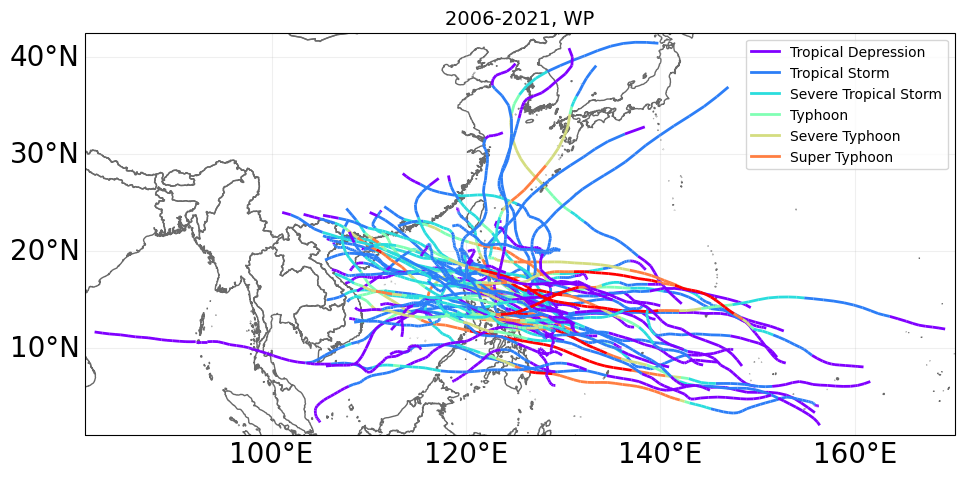

In [4]:
# Plots all tracks in time frame
# Is supposed to plot the tracks, doesn't work --> not required
ax = Typhoons.plot()
ax.get_legend()._loc = 1 # correct legend location
ax.set_title('2006-2021, WP',fontsize = 14) # set title
plt.show()
plt.close()


In [5]:
# Select names and storm id's of storms
names=[[tr.name,tr.sid] for tr in Typhoons.data]

114.27790168600006 4.587294497000073 126.60482466300004 21.12180803600006


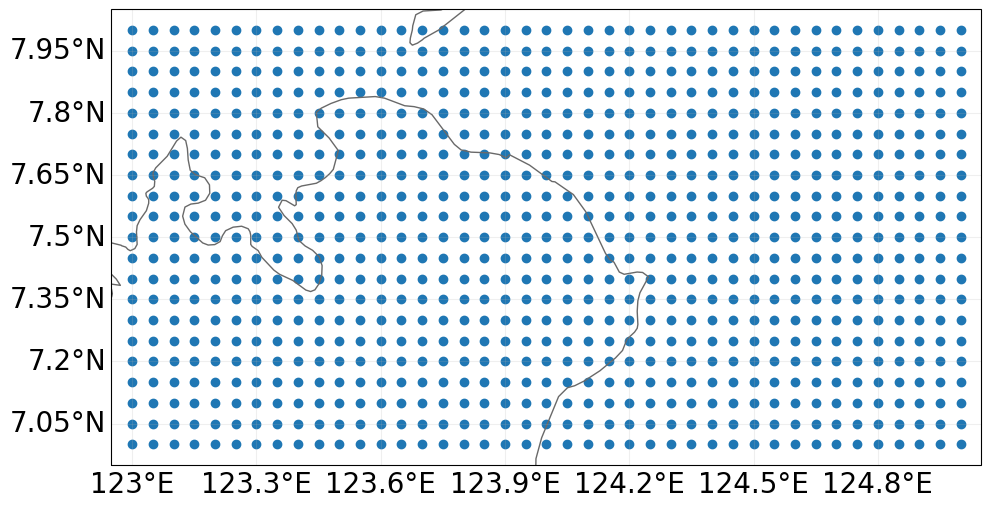

In [33]:
file_name = "IBF_typhoon_model\\data\\wind_data\\input\\phl_admin3_simpl2.geojson"
path = os.path.join(cdir, file_name)
admin=gpd.read_file(path)

minx, miny, maxx, maxy = admin.total_bounds

print(minx, miny, maxx, maxy)

minx = 123
maxx = 125
miny = 7
maxy = 8

cent = Centroids()
# cent.set_raster_from_pnt_bounds((minx,miny,maxx,maxy), res=0.05)
cent.set_raster_from_pnt_bounds((minx,miny,maxx,maxy), res=0.05)
cent.check()
cent.plot()
plt.show()
plt.close()

#TODO set the bounds to the bounds of the shape file of the Philippines
#TODO this needs to be changed in the pipeline to obtain complete information
# cent = Centroids()
# cent.set_raster_from_pnt_bounds((118,6,127,19), res=0.05)
# cent.check()
# cent.plot()

In [7]:
df = pd.DataFrame(data=cent.coord)
df["centroid_id"] = "id"+(df.index).astype(str)  
centroid_idx=df["centroid_id"].values
ncents = cent.size
df=df.rename(columns={0: "lat", 1: "lon"})
#calculate wind field for each ensamble members 
# Instead of one grid point for each municipalities: uses a range of gridpoints and calculates value for each point
# Eventually select a specific point in municipality based on condition

In [8]:
def adjust_tracks(forcast_df):
    track = xr.Dataset(
        data_vars={
            'max_sustained_wind': ('time', 0.514444*forcast_df.max_sustained_wind.values),
            'environmental_pressure': ('time', forcast_df.environmental_pressure.values),
            'central_pressure': ('time',forcast_df.central_pressure.values),
            'lat': ('time',forcast_df.lat.values),
            'lon': ('time', forcast_df.lon.values),
            'radius_max_wind':('time', forcast_df.radius_max_wind.values),  
            'radius_oci':('time',forcast_df.radius_oci.values), 
            'time_step':('time',np.full_like(forcast_df.time_step.values, 3, dtype=float)),
        },
        coords={
            'time': forcast_df.time.values,
        },
        attrs={
            'max_sustained_wind_unit': 'm/s',
            'central_pressure_unit': 'mb',
            'name': forcast_df.name,
            'sid': forcast_df.sid,#+str(forcast_df.ensemble_number),
            'orig_event_flag': forcast_df.orig_event_flag,
            'data_provider': forcast_df.data_provider,
            'id_no': forcast_df.id_no,
            'basin': forcast_df.basin,
            'category': forcast_df.category,
        }
    )
    track = track.set_coords(['lat', 'lon'])
    return track

In [9]:
tracks=TCTracks()
tracks.data=[adjust_tracks(tr) for tr in  Typhoons.data]

In [10]:
# Shows specific data for one of the typhoons
tracks.data[0]

<xarray.Dataset>
Dimensions:                 (time: 123)
Coordinates:
    lat                     (time) float32 6.1 6.21 6.4 6.72 ... 11.5 11.59 11.7
    lon                     (time) float32 149.8 149.3 148.8 ... 83.3 82.59 81.8
  * time                    (time) datetime64[ns] 2006-11-24T12:00:00 ... 200...
Data variables:
    max_sustained_wind      (time) float32 7.717 7.717 7.717 ... 7.717 7.717
    environmental_pressure  (time) float64 1.008e+03 1.008e+03 ... 1.006e+03
    central_pressure        (time) float32 1.006e+03 1.006e+03 ... 1.006e+03
    radius_max_wind         (time) float32 0.0 0.0 0.0 40.0 ... 0.0 0.0 0.0 0.0
    radius_oci              (time) float32 0.0 0.0 0.0 150.0 ... 0.0 0.0 0.0 0.0
    time_step               (time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
Attributes:
    max_sustained_wind_unit:  m/s
    central_pressure_unit:    mb
    name:                     DURIAN
    sid:                      2006329N06150
    orig_event_flag:          True
    data_provider:            ibtracs_usa
    id_no:                    2006329006150.0
    basin:                    <xarray.DataArray 'basin' (time: 123)>\narray([...
    category:                 4

In [11]:
# tracks1=TCTracks()
# tracks1.data=tracks.data[0]
# TYphoon = TropCyclone()
# TYphoon.set_from_tracks(tracks1, cent, store_windfields=True)

tracks.equal_timestep(0.5)

# define a new typhoon class
TYphoon = TropCyclone()
TYphoon.set_from_tracks(tracks, cent, store_windfields=True)

C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\xarray\core\common.py:1123: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  "Passing ``keep_attrs`` to ``resample`` has no effect and will raise an"
C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\xarray\core\common.py:1123: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  "Passing ``keep_attrs`` to ``resample`` has no effect and will raise an"
C:\Users\Marieke\anaconda3\envs\Rice_Field_Damage_Philippines\lib\site-packages\xarray\core\common.py:1123: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``k

In [12]:
# plot intensity for one of the ensambles
# TYphoon.plot_intensity(event=Typhoons.data[0].sid)
# plt.show()
# plt.close()

In [13]:
df = pd.DataFrame(data=cent.coord)
df["centroid_id"] = "id"+(df.index).astype(str)  
centroid_idx=df["centroid_id"].values
ncents = cent.size
df=df.rename(columns={0: "lat", 1: "lon"})
#TODO what does this threshold hold do and why is it set to this value?
#TODO set threshold value to 0 to delete all entirely irrelevant observation
threshold=10
threshold = 0.1 
#calculate wind field for each ensamble members 

list_intensity=[]
distan_track=[]


for tr in tracks.data:
  print(tr.name)

  track = TCTracks() 
  typhoon = TropCyclone()
  track.data=[tr]
  typhoon.set_from_tracks(track, cent, store_windfields=True)
  windfield=typhoon.windfields
  nsteps = windfield[0].shape[0]
  centroid_id = np.tile(centroid_idx, nsteps)
  intensity_3d = windfield[0].toarray().reshape(nsteps, ncents, 2)
  intensity = np.linalg.norm(intensity_3d, axis=-1).ravel()

  timesteps = np.repeat(tr.time.values, ncents)
  timesteps = timesteps.reshape((nsteps, ncents)).ravel()
  inten_tr = pd.DataFrame({
      'centroid_id': centroid_id,
      'value': intensity,
      'timestamp': timesteps,
  })


  inten_tr = inten_tr[inten_tr.value > threshold]
  
  inten_tr['storm_id'] = tr.sid
  list_intensity.append(inten_tr)
  distan_track1=[]
  for index, row in df.iterrows():
      dist=np.min(np.sqrt(np.square(tr.lat.values-row['lat'])+np.square(tr.lon.values-row['lon'])))
      distan_track1.append(dist*111)
  dist_tr = pd.DataFrame({'centroid_id': centroid_idx,'value': distan_track1})
  dist_tr['storm_id'] = tr.sid
  distan_track.append(dist_tr)      
 

DURIAN
KETSANA
PARMA
MIRINAE
KOMPASU
AERE
MEARI
NOCK-TEN
NANMADOL
NESAT
NALGAE
WASHI
KAI-TAK
BOPHA
UTOR
TRAMI
USAGI
NARI
KROSA
HAIYAN
LINGLING
RAMMASUN
MATMO
KALMAEGI
FUNG-WONG
HAGUPIT
JANGMI
MEKKHALA
LINFA
GONI
MUJIGAE
KOPPU
MELOR
SARIKA
HAIMA
TOKAGE
NOCK-TEN
PAKHAR
KHANUN
HAIKUI
KAI-TAK
TEMBIN
MALIKSI
MANGKHUT
YUTU
DANAS
NAKRI
KAMMURI
PHANFONE
VONGFONG
SAUDEL
MOLAVE
GONI
ATSANI
VAMCO
KROVANH


In [14]:
df.shape

(82336, 3)

In [15]:

#? Changed document source, geojson instead of shape
file_name = "IBF_typhoon_model\\data\\wind_data\\input\\phl_admin3_simpl2.geojson"
path = os.path.join(cdir, file_name)
admin=gpd.read_file(path)



df_ = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))
#df.to_crs({'init': 'epsg:4326'})
df_.crs = {'init': 'epsg:4326'}
df_admin = sjoin(df_, admin, how="left")
#TODO why is this added? --> commented out
#To remove points that are in water
df_admin=df_admin.dropna()

ipykernel_launcher:11: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326



In [16]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import nearest_points

# For not all municipalities an entry is added
# Find municipalities that are missing
mun_missing = admin[admin['adm3_pcode'].isin(df_admin['adm3_pcode']) == False]

#? Add the centroid for each municipalities to fill values for closest points for missing entries
mun_missing['centroid'] = mun_missing['geometry'].centroid

print(f"Number of missing municipalities {len(mun_missing)}")

# Add the nearest point that is present
mun_missing['nearest_geometry'] = ""

for index, row in mun_missing.iterrows():
    point = row.centroid
    multipoint = df_.geometry.unary_union
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    mun_missing.loc[index, 'nearest_geometry'] = nearest_geom

centroid_id_list = []

for cen in mun_missing['nearest_geometry']:

    cid = df_[df_['geometry']==cen]['centroid_id'].values[0]
    centroid_id_list.append(cid)

mun_missing['centroid_id']= centroid_id_list

ipykernel_launcher:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Number of missing municipalities 87


In [29]:
mun_missing.head()

adm3_en   adm3_pcode   adm2_pcode   adm1_pcode    glat     glon  \
20     Linamon  PH103510000  PH103500000  PH100000000   8.168  124.155   
38  Datu Unsay  PH153827000  PH153800000  PH150000000   6.890  124.394   
39    Banayoyo  PH012902000  PH012900000  PH010000000  17.246  120.493   
48     Caoayan  PH012907000  PH012900000  PH010000000  17.535  120.391   
61        Loay  PH071228000  PH071200000  PH070000000   9.611  124.016   

                                             geometry  \
20  MULTIPOLYGON (((124.12380 8.18767, 124.12471 8...   
38  MULTIPOLYGON (((124.46915 6.91897, 124.45972 6...   
39  MULTIPOLYGON (((120.51343 17.23853, 120.51605 ...   
48  MULTIPOLYGON (((120.40343 17.55167, 120.40360 ...   
61  MULTIPOLYGON (((124.00916 9.61869, 124.00972 9...   

                      centroid                             nearest_geometry  \
20   POINT (124.15444 8.16793)  POINT (124.1779016859995 8.171808035999877)   
38   POINT (124.39362 6.88995)  POINT (124.3779016859995 6.871808035999859)   
39  POINT (120.49327 17.24570)  POINT (120.4779016859997 17.22180803600001)   
48  POINT (120.39071 17.53491)  POINT (120.3779016859997 17.52180803600001)   
61   POINT (124.01615 9.61068)  POINT (124.0279016859995 9.621808035999898)   

   centroid_id  
20     id64430  
38     id70882  
39     id19468  
48     id17978  
61     id57235

In [30]:
mun_missing.shape

(87, 10)

In [17]:
# Combine the dataframes
mun_missing_new = pd.merge(df_, mun_missing[['centroid_id', 'adm3_en', 'adm3_pcode', 'adm2_pcode', 'adm1_pcode', 'glat', 'glon']], left_on=['centroid_id'], right_on=['centroid_id'], how='right')

df_admin_new = pd.concat([df_admin, mun_missing_new], join='outer')



In [18]:
df_admin = df_admin_new

df_admin.head()

unq = df_admin['adm3_pcode'].unique()
print(f"Number of unique municipalities {print(len(unq))}")


1647
Number of unique municipalities None


In [19]:
# df_admin.head()
# df_intensity = pd.concat(list_intensity)
# df_intensity_new=pd.merge(df_intensity, df_admin, how='right', on='centroid_id')
# df_intensity_new.shape

In [20]:
# df_intensity_new.head()
# for typh in df_intensity_new['storm_id'].unique():

#     t = len(df_intensity_new[df_intensity_new['storm_id']==typh]['adm3_pcode'].unique())
#     print(t)

In [21]:
df_intensity = pd.concat(list_intensity)
df_intensity=pd.merge(df_intensity, df_admin, how='outer', on='centroid_id')


In [28]:
df_intensity.shape
df_intensity[df_intensity['lat'].notnull()].head()

MemoryError: Unable to allocate 8.54 GiB for an array with shape (6, 191030111) and data type float64

In [23]:
df_intensity = pd.concat(list_intensity)
df_intensity=pd.merge(df_intensity, df_admin, how='outer', on='centroid_id')
#df_intensity = gpd.GeoDataFrame(df_intensity, geometry=gpd.points_from_xy(df_intensity.lon, df_intensity.lat))
df_intensity=df_intensity.dropna()
#df_intensity = gpd.GeoDataFrame(df_intensity, geometry=gpd.points_from_xy(df_intensity.lon, df_intensity.lat))
#? Only keeps observations with an intensity higher than 12 --> why --> why not cancel out at the end when preparing the data so it is easier to adjust
#? Obtains the maximum intensity for each municipality and storm_id combination & also return the count (how often the combination occurs in the set)
#TODO changed to not filtering based on intensity
# df_intensity=df_intensity[df_intensity['value'].gt(12)].groupby(['adm3_pcode','storm_id'],as_index=False).agg({"value":['count', 'max']}) 
df_intensity=df_intensity[df_intensity['value'].gt(0)].groupby(['adm3_pcode','storm_id'],as_index=False).agg({"value":['count', 'max']}) 
# rename columns
df_intensity.columns = [x for x in ['adm3_pcode','storm_id','value_count','v_max']]
#########################################################################################
df_track = pd.concat(distan_track)
df_track=pd.merge(df_track, df_admin, how='outer', on='centroid_id')
df_track=df_track.dropna()
#? Obtains the minimum track distance for each municipality and storm_id combination
df_track_=df_track.groupby(['adm3_pcode','storm_id'],as_index=False).agg({'value':'min'}) 
df_track_.columns = [x for x in ['adm3_pcode','storm_id','dis_track_min']]#join_left_df_.columns.ravel()]
typhhon_df = pd.merge(df_intensity, df_track_,  how='left', on=['adm3_pcode','storm_id']) 
#typhhon_df.to_csv(os.path.join('/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/historical_typhoons_intensity.csv')

MemoryError: Unable to allocate 8.54 GiB for an array with shape (6, 191030111) and data type object

In [ ]:
len(tracks.data)
print(typhhon_df.shape)
typhhon_df.shape

(916, 5)


(916, 5)

In [ ]:
# Check if there are duplicates for municipality and storm_id
duplicate = typhhon_df[typhhon_df.duplicated(subset=['adm3_pcode', 'storm_id'], keep=False)]
duplicate.head()

# No duplicates: final dataframe contains vmax and dis_track_min fpr each storm and municipality

Empty DataFrame
Columns: [adm3_pcode, storm_id, value_count, v_max, dis_track_min]
Index: []

In [ ]:
typhhon_df.head()
np.min(typhhon_df['v_max'])
np.max(typhhon_df['dis_track_min'])

502.199265459956

In [ ]:
# Add the changes that are related to the wind variables and present in the R script
typhhon_df['vmax_gust'] = typhhon_df['v_max'] *1.21*1.9*1.94384 #knot(1.94384) and 1.21 is conversion factor for 10 min average to 1min average
typhhon_df['vmax_gust_mph'] = typhhon_df['v_max'] *1.21*1.9*2.23694 #mph 1.9 is factor to drive gust and sustained wind 
typhhon_df['vmax_sust_mph'] = typhhon_df['v_max'] *1.21*2.23694
typhhon_df['vmax_sust'] = typhhon_df['v_max'] *1.21*1.94384


In [ ]:
file_name = 'IBF_typhoon_model\\data\\wind_data\\output\\historical_typhoons_wind_new.csv'
path = os.path.join(cdir, file_name)

typhhon_df.to_csv(path)

In [12]:
%r
# IMPORT LIBRARY
library(stringr)

UsageError: Line magic function `%r` not found.


In [ ]:
%r
# IMPORT LIBRARY
library(stringr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(httr)
library(sf)
library(raster)
library(randomForest)
library(rlang)
library(plyr)
library(lubridate)
library(ranger)
library(tmap)



main_directory<-'/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/'

source('/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/lib_r/settings.R')
source('/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/lib_r/data_cleaning_forecast.R')
source('/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/lib_r/track_interpolation.R')


geo_variable <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model//data/geo_variable.csv")
#mode_classification1 <- readRDS(paste0(main_directory,"./models/xgboost_classify.rds"))
#mode_continious1 <- readRDS(paste0(main_directory,"./models/xgboost_regression.rds"))
  
#------------------------- define functions ---------------------------------

ntile_na <- function(x,n){
  notna <- !is.na(x)
  out <- rep(NA_real_,length(x))
  out[notna] <- ntile(x[notna],n)
  return(out)
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

 filter, lag

The following objects are masked from ‘package:base’:

 intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked _by_ ‘.GlobalEnv’:

 complete

Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 7.0.0
Loading required package: sp

Attaching package: ‘raster’

The following object is masked from ‘package:tidyr’:

 extract

The following object is masked from ‘package:dplyr’:

 select

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

 combine

The following object is masked from ‘package:ggplot2’:

 margin

------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------------------------------------

Attaching package: ‘plyr’

The following objects are masked from ‘package:dplyr’:

 arrange, count, desc, failwith, id, mutate, rename, summarise,
 summarize


Attaching package: ‘lubridate’

The following objects are masked from ‘package:raster’:

 intersect, union

The following objects are masked from ‘package:dplyr’:

 intersect, setdiff, union

The following objects are masked from ‘package:base’:

 date, intersect, setdiff, union


Attaching package: ‘ranger’

The following object is masked from ‘package:randomForest’:

 importance

 Reading layer `phl_admin3_simpl2' from data source `/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/data-raw' using driver `ESRI Shapefile'
Simple feature collection with 1647 features and 6 fields
Geometry type: MULTIPOLYGON
Dimension: XY
Bounding box: xmin: 114.2779 ymin: 4.587294 xmax: 126.6048 ymax: 21.12181
Geodetic CRS: WGS 84
Reading layer `phl_admin1_gadm_pcode' from data source `/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/data-raw' using driver `ESRI Shapefile'
Simple feature collection with 17 features and 11 fields
Geometry type: MULTIPOLYGON
Dimension: XY
Bounding box: xmin: 116.9283 ymin: 4.58694 xmax: 126.6054 ymax: 21.07014
Geodetic CRS: WGS 84
Reading layer `phl_admin1_buffer' from data source `/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/data-raw' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 1 field
Geometry type: MULTIPOLYGON
Dimension: XY
Bounding box: xmin: 116.8484 ymin: 4.507234 xmax: 126.6853 ymax: 21.1499
Geodetic CRS: WGS 84

In [ ]:
%r


# BUILD WIND DATA MATRIC FOR NEW TYPHOON 

# Read the historical typhoon wind sheet into excel
# Replaces track distance that is below 1 with 1
# Adds the province code (first 10 characters of municipality code)
results_folder="/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields"
past_typhoon_wind <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/historical_typhoons_wind.csv")%>%dplyr::mutate(dis_track_min=ifelse(dis_track_min<1,1,dis_track_min),Mun_Code=adm3_pcode,pcode=as.factor(substr(adm3_pcode, 1, 10)))


X adm3_pcode storm_id value_count v_max dis_track_min Mun_Code
1 0 PH012801000 2011266N13139 193 24.49168 211.226851 PH012801000
2 1 PH012801000 2012331N03157 137 17.30778 163.559654 PH012801000
3 2 PH012801000 2013220N12137 111 17.00776 191.753170 PH012801000
4 3 PH012801000 2013301N13142 216 50.28270 3.747997 PH012801000
5 4 PH012801000 2014254N10142 144 44.56830 50.500917 PH012801000
6 5 PH012801000 2014260N13135 262 18.28705 11.174090 PH012801000
 pcode
1 PH01280100
2 PH01280100
3 PH01280100
4 PH01280100
5 PH01280100
6 PH01280100

In [ ]:
%r


#################################################################
# BUILD RAIN DATA MATRIC FOR NEW TYPHOON
# 
# Read the Rain data --> not needed? 
past_typhoon_rain <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/PHL_admin3_zonal_statistics_2021_05_13.csv") 
past_typhoon_rain2 <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/all_rainfall.csv") 
past_typhoon_rain2

Mun_Code typhoon rainfll_max ranfall_sum
1 PH012801000 Bopha 57.60 134.40
2 PH012801000 conson 7.20 21.60
3 PH012801000 Durian 91.20 268.80
4 PH012801000 Fengshen 12.00 45.60
5 PH012801000 Fung-wong 120.00 408.00
6 PH012801000 Goni 146.40 643.20
7 PH012801000 Hagupit 12.00 33.60
8 PH012801000 Haima 79.20 314.40
9 PH012801000 Haiyan 84.00 225.60
10 PH012801000 Kalmaegi 57.60 134.40
11 PH012801000 ketsana 52.80 189.60
12 PH012801000 Koppu 72.00 256.80
13 PH012801000 Krosa 153.60 350.40
14 PH012801000 Lingling 0.00 0.00
15 PH012801000 Mangkhut 172.80 518.40
16 PH012801000 Mekkhala 52.80 132.00
17 PH012801000 Melor 127.20 326.40
18 PH012801000 Mujigae 24.00 72.00
19 PH012801000 Nari 141.60 400.80
20 PH012801000 Nesat 62.40 278.40
21 PH012801000 Nock-Ten 36.00 108.00
22 PH012801000 Noul 21.60 84.00
23 PH012801000 Rammasun 48.00 189.60
24 PH012801000 Sarika 67.20 216.00
25 PH012801000 Trami 67.20 232.80
26 PH012801000 Usagi 153.60 427.20
27 PH012801000 Utor 69.60 312.00
28 PH012802000 Bopha 39.60 115.20
29 PH012802000 conson 40.80 87.60
30 PH012802000 Durian 26.40 60.00
31 PH012802000 Fengshen 4.80 24.00
32 PH012802000 Fung-wong 147.60 472.80
33 PH012802000 Goni 262.80 790.80
34 PH012802000 Hagupit 2.40 8.40
35 PH012802000 Haima 74.40 284.40
36 PH012802000 Haiyan 61.20 182.40
37 PH012802000 Kalmaegi 79.20 199.20
38 PH012802000 ketsana 51.60 180.00
39 PH012802000 Koppu 87.60 306.00
40 PH012802000 Krosa 141.60 324.00
41 PH012802000 Lingling 0.00 0.00
42 PH012802000 Mangkhut 80.40 392.40
43 PH012802000 Mekkhala 21.60 46.80
44 PH012802000 Melor 141.60 321.60
45 PH012802000 Mujigae 21.60 48.00
46 PH012802000 Nari 56.40 195.60
47 PH012802000 Nesat 58.80 270.00
48 PH012802000 Nock-Ten 18.00 52.80
49 PH012802000 Noul 26.40 66.00
50 PH012802000 Rammasun 39.60 212.40
51 PH012802000 Sarika 74.40 238.80
52 PH012802000 Trami 111.60 500.40
53 PH012802000 Usagi 116.40 331.20
54 PH012802000 Utor 111.60 460.80
55 PH012803000 Bopha 36.00 91.20
56 PH012803000 conson 81.60 180.00
57 PH012803000 Durian 40.80 86.40
58 PH012803000 Fengshen 9.60 31.20
59 PH012803000 Fung-wong 201.60 669.60
60 PH012803000 Goni 312.00 938.40
61 PH012803000 Hagupit 4.80 14.40
62 PH012803000 Haima 108.00 348.00
63 PH012803000 Haiyan 52.80 160.80
64 PH012803000 Kalmaegi 93.60 208.80
65 PH012803000 ketsana 52.80 168.00
66 PH012803000 Koppu 129.60 432.00
67 PH012803000 Krosa 103.20 249.60
68 PH012803000 Lingling 0.00 0.00
69 PH012803000 Mangkhut 117.60 448.80
70 PH012803000 Mekkhala 38.40 81.60
71 PH012803000 Melor 115.20 264.00
72 PH012803000 Mujigae 19.20 40.80
73 PH012803000 Nari 64.80 194.40
74 PH012803000 Nesat 62.40 218.40
75 PH012803000 Nock-Ten 50.40 124.80
76 PH012803000 Noul 9.60 26.40
77 PH012803000 Rammasun 28.80 122.40
78 PH012803000 Sarika 108.00 297.60
79 PH012803000 Trami 151.20 652.80
80 PH012803000 Usagi 69.60 230.40
81 PH012803000 Utor 151.20 655.20
82 PH012804000 Bopha 84.00 211.20
83 PH012804000 conson 28.80 60.00
84 PH012804000 Durian 21.60 67.20
85 PH012804000 Fengshen 7.20 33.60
86 PH012804000 Fung-wong 115.20 396.00
87 PH012804000 Goni 184.80 681.60
88 PH012804000 Hagupit 4.80 19.20
89 PH012804000 Haima 74.40 285.60
90 PH012804000 Haiyan 72.00 199.20
91 PH012804000 Kalmaegi 103.20 230.40
92 PH012804000 ketsana 189.60 480.00
93 PH012804000 Koppu 124.80 343.20
94 PH012804000 Krosa 163.20 350.40
95 PH012804000 Lingling 0.00 0.00
96 PH012804000 Mangkhut 96.00 386.40
97 PH012804000 Mekkh
*** WARNING: skipped 117652 bytes of output ***

 Bopha 0.60 1.20
2405 PH015513000 conson 22.80 75.00
2406 PH015513000 Durian 16.20 40.80
2407 PH015513000 Fengshen 43.20 174.00
2408 PH015513000 Fung-wong 163.20 411.00
2409 PH015513000 Goni 88.20 483.60
2410 PH015513000 Hagupit 3.60 7.80
2411 PH015513000 Haima 82.20 311.40
2412 PH015513000 Haiyan 21.60 59.40
2413 PH015513000 Kalmaegi 213.60 477.00
2414 PH015513000 ketsana 69.00 208.80
2415 PH015513000 Koppu 264.00 698.40
2416 PH015513000 Krosa 11.40 30.60
2417 PH015513000 Lingling 0.60 1.20
2418 PH015513000 Mangkhut 137.40 566.

In [ ]:
%r


#################################################################
# BUILD RAIN DATA MATRIC FOR NEW TYPHOON 
past_typhoon_rain <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/PHL_admin3_zonal_statistics_2021_05_13.csv") 
past_typhoon_rain2 <- read.csv("/dbfs/mnt/TyphoonData/typhoon/Bronze/TyphoonModel/Typhoon-Impact-based-forecasting-model/past_typhoon_windfields/all_rainfall.csv") 
all_rainfall

past_typhoon_rain <- past_typhoon_rain%>%
  group_by(pcode,typhoon_name)%>%
  dplyr::summarise(rain_max=max(value)/10,rain_mean = mean(value)/10)%>%ungroup()%>%
  dplyr::mutate(Mun_Code=paste0(pcode,'0'),typhoon=as.factor(typhoon_name))


###################################################################### 
# BUILD HAZARD DATA MATRIC FOR NEW TYPHOON 
past_typhoon_hazard<-past_typhoon_wind%>%
  left_join(past_typhoon_rain,by = c("Mun_Code","typhoon"))%>%
  dplyr::mutate(typhoon_name=typhoon,
                typhoon_name=as.factor(typhoon_name),
                rainfall_24h=rain_max,
                dist_track=dis_track_min,
                gust_dur=0,
                sust_dur=0,
                vmax_gust=v_max*1.21*1.9*1.94384,  #knot(1.94384) and 1.21 is conversion factor for 10 min average to 1min average
                vmax_gust_mph=v_max*1.21*1.9*2,23694, #mph 1.9 is factor to drive gust and sustained wind 
                vmax_sust_mph=v_max*1.21*2,23694,
                vmax_sust=v_max*1.21*1.94384)%>%     #knot(1.94384) and 1.21 is conversion factor for 10 min average to 1min average 
  dplyr::select(Mun_Code,vmax_gust,vmax_gust_mph,vmax_sust_mph,vmax_sust,dist_track,rainfall_24h,gust_dur,sust_dur,rain_mean,storm_id,typhoon_name)

# BUILD DATA MATRIC FOR pre disaster indicators
data_pre_disaster <- geo_variable%>%
  left_join(material_variable2 %>% dplyr::select(-Region,-Province,-Municipality_City), by = "Mun_Code") %>%
  left_join(data_matrix_new_variables , by = "Mun_Code")


# BUILD DATA MATRIC FOR NEW TYPHOON 
data_new_typhoon <- past_typhoon_hazard%>%left_join(data_pre_disaster,by="Mun_Code")


data <- clean_typhoon_forecast_data_ensamble(data_new_typhoon) %>% na.omit() # Randomforests don't handle NAs, you can impute in the future 

model_input <- data %>% dplyr::select(-GEN_typhoon_name,
                -GEN_typhoon_id,
                -GEO_n_households,
                #-GEN_mun_code,
                -contains('DAM_'),
                -GEN_mun_name) 